# Second attempt at building a RISE explainer for embedded spaces

In the previous notebook we built a first attempt using two labra doodles. We had some success, but still need:
1. more understanding of the output and
2. need to run on several examples to get a feeling of the robustness of the method and
3. also to assess its performance on very different images (since we focused on very similar images before).

We also at some point will look into multimodal models, but this will require changing the API to input two models. This we will do in a next step, after we understand the basics better.

Image combinations to try out here:
- Bee vs fly (similar in insectiness but also differences)
- Flower vs car
- Car vs bike
- Image with both "cat and labradoodle" vs cat and vs labradoodle.

We need to take care with backgrounds that could be distinguishing, probably keep them similar when trying to focus on the actual objects? Or not, but in any case, let's be aware.

In [1]:
import numpy as np
from tqdm import tqdm
from sklearn.metrics import pairwise_distances

In [2]:
import embeddings

In [23]:
import importlib
importlib.reload(embeddings)

<module 'embeddings' from '/Users/pbos/projects/dianna/dianna/embedding_WIP/embeddings.py'>

In [6]:
embeddings.set_all_the_seeds()

In [7]:
model = embeddings.Model()

/Users/pbos/sw/miniconda3/envs/dianna/lib/python3.9/site-packages/keras/backend.py:414: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


In [8]:
urls = ['https://www.keystonepuppies.com/wp-content/uploads/2019/05/Tike-Mini-Labradoodle.jpg',
        'https://www.lomondhillslabradoodles.co.uk/wp-content/uploads/2018/12/IMG_4531-e1549365547619.jpg']
filenames = [embeddings.download(url) for url in urls]

img_dog1, x_dog1 = embeddings.load_img(filenames[0], model.input_size)
img_dog2, x_dog2 = embeddings.load_img(filenames[1], model.input_size)

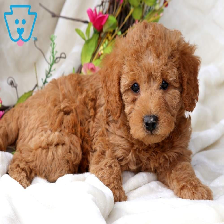

In [9]:
img_dog1

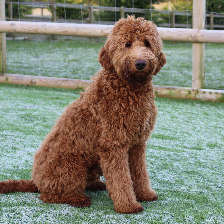

In [10]:
img_dog2

In [11]:
def get_masked_predictions(model, inp, masks, batch_size=10):
    preds = []
    # Make sure multiplication is being done for correct axes
    masked = inp * masks
    N = len(masks)
    for i in tqdm(range(0, N, batch_size), desc='Explaining'):
        preds.append(model.run_on_batch(masked[i:min(i+batch_size, N)]))
    preds = np.concatenate(preds)
    return preds

def explain(model, inp, reference_inp, masks, batch_size=10, preds=None):
    if preds is None:
        preds = get_masked_predictions(model, inp, masks, batch_size=batch_size)

    reference_pred = model.run_on_batch(reference_inp)
    distances = pairwise_distances(preds, reference_pred, metric='cosine') / 2
    mask_weights = np.exp(-distances)
    print('weights.shape', mask_weights.shape)

    sal = mask_weights.T.dot(masks.reshape(len(masks), -1)).reshape(-1, *model.input_size)

    normalization = mask_weights.sum()

    sal = sal / normalization
    return sal

In [12]:
masks = embeddings.generate_masks(3000, 8, 0.5, model.input_size)

Generating masks: 100%|██████████| 3000/3000 [00:12<00:00, 243.92it/s]


In [13]:
masked_predictions = get_masked_predictions(model, x_dog1, masks)

Explaining: 100%|██████████| 300/300 [08:45<00:00,  1.75s/it]


In [73]:
sal = explain(model, x_dog1, x_dog2, masks, preds=masked_predictions)

weights.shape (3000, 1)


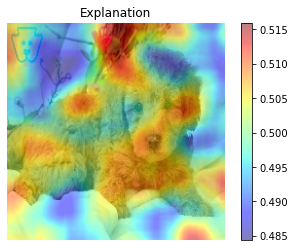

In [74]:
fig = embeddings.plot_explainer(img_dog1, sal[0])

Unfortunately, it seems now that the results in the previous notebook may have been flukes, or we just interpreted things too positively. Either way, we cannot reproduce the stable good-ish results we got before. So, we need again to dig deeper into why, because the idea seems sound: use distance to weigh the masked images.

To get a better feeling of how that works, we will look at a couple of masked images, run them through the model, see what distances to the reference prediction they yield and see if this makes sense and whether we expect this will yield useful results through the RISE algorithm or whether distances are too noisy and close together to be useful.

We could do random masks, but maybe it's even more insightful to make some custom ones focusing specifically on the doggy parts.

For this happy occasion, we will also be switching images, just to get a broader feel of how the model and explainer behave.

In [25]:
_urls = ['https://www.publicdomainpictures.net/pictures/50000/velka/liten-fluga.jpg',
         'https://publicdomainpictures.net/pictures/140000/velka/bee-painting.jpg']
_filenames = [embeddings.download(url) for url in _urls]

img_fly, x_fly = embeddings.load_img(_filenames[0], model.input_size)
img_bee, x_bee = embeddings.load_img(_filenames[1], model.input_size)

Let's see if it works and also see if setting the seed works now.

In [30]:
embeddings.set_all_the_seeds()

In [31]:
masks_fly = embeddings.generate_masks(500, 8, 0.5, model.input_size)

Generating masks: 100%|██████████| 500/500 [00:02<00:00, 209.39it/s]


In [32]:
masked_predictions_fly = get_masked_predictions(model, x_fly, masks_fly)

Explaining: 100%|██████████| 50/50 [01:28<00:00,  1.77s/it]


In [33]:
sal_fly = explain(model, x_fly, x_bee, masks_fly, preds=masked_predictions_fly)

weights.shape (500, 1)


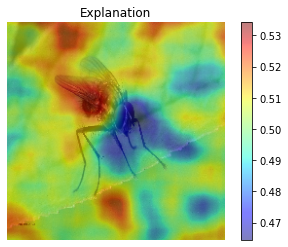

In [34]:
_fig = embeddings.plot_explainer(img_fly, sal_fly[0])

Explaining: 100%|██████████| 50/50 [01:20<00:00,  1.60s/it]


weights.shape (500, 1)


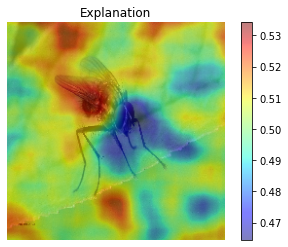

In [39]:
embeddings.set_all_the_seeds()
_masks_fly = embeddings.generate_masks(500, 8, 0.5, model.input_size)
_masked_predictions_fly = get_masked_predictions(model, x_fly, _masks_fly)
_sal_fly = explain(model, x_fly, x_bee, _masks_fly, preds=_masked_predictions_fly)
_fig = embeddings.plot_explainer(img_fly, _sal_fly[0])

Perfect match, setting seeds works.

Now, to mask images one by one and look at the distances.

In [40]:
def get_masked_image_prediction(inp, mask):
    masked = inp * mask
    prediction = model.run_on_batch(masked)
    return prediction

In [42]:
pred_0 = get_masked_image_prediction(x_fly, masks_fly[0])

In [45]:
pred_0.argsort()

array([[864, 687, 963, 625, 490, 467, 860, 477, 771, 800, 734, 122, 406,
        766, 550, 476, 148, 726, 817, 536, 857, 524, 244, 423, 926, 627,
        686, 967, 541, 403, 788, 628, 408, 874, 623, 777, 404, 757, 564,
        865, 729, 147, 965, 931, 822, 581,  51, 174, 498, 709, 260, 261,
        582, 592, 867, 891, 553, 473, 962, 573, 567, 751, 736, 685, 933,
        884, 116, 422, 661, 547, 154, 458, 896, 881, 787, 675, 927, 901,
        969, 450, 914, 959, 535, 479, 615, 827, 194, 121, 846, 466, 624,
        928, 612, 430, 540, 579, 961, 526, 495, 811, 544, 960, 768, 909,
        328, 665, 539, 894, 630, 119, 464, 802, 521,   2, 869, 932, 285,
        228, 431, 847, 502, 778, 496, 710, 681, 799, 917, 702, 105, 598,
        705, 739, 785, 533, 781, 754, 230, 263, 854, 652, 659, 242, 569,
        719, 642, 690, 493, 747, 576, 537, 886, 744, 454, 878, 964, 532,
        717, 602, 830, 444, 192, 439, 882, 863, 560, 654,  69, 935, 102,
        486, 551, 118, 283, 415, 548, 741,   3, 871

In [49]:
embeddings.class_name(74)

'garden_spider'

Hm, let's take a quick look with DIANNA to see why it classifies the fly as all these insects, because maybe it picks other things than just flies because of the leaf?

In [70]:
import dianna
import onnx

In [71]:
model = onnx.load("/Users/pbos/Downloads/resnet50-v2-7.onnx")

In [75]:
model.graph.input

In [69]:
dianna.explain_image("/Users/pbos/Downloads/resnet50-v2-7.onnx", x_fly[0], method="RISE", axis_labels={2: 'channels'})

InvalidArgument: [ONNXRuntimeError] : 2 : INVALID_ARGUMENT : Got invalid dimensions for input: data for the following indices
 index: 0 Got: 50 Expected: 1
 index: 1 Got: 224 Expected: 3
 index: 3 Got: 3 Expected: 224
 Please fix either the inputs or the model.

Hm, well, there may be some improvements to be made to our interface.

1. It's hard to inspect the model if you don't load it yourself beforehand, so we should also allow passing raw models, not just filenames or functions.
2. The error message when forgetting to use the required axis_labels implies that they should be passed via `labels`, but this is confusing. Chris fixed this already on main.
3. We should also have a default method for the really lazy users (like us).
4. It still doesn't work, we have to manually get the axes in order, that's an annoying chore.